# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.


In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.



In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

!ls

AZDIAS_Feature_Summary.csv	  terms_and_conditions
Data_Dictionary.md		  Udacity_AZDIAS_Subset.csv
general_k_model.sav		  Udacity_CUSTOMERS_Subset.csv
Identify_Customer_Segments.ipynb


In [3]:
#opening data dictionary
!cat Data_Dictionary.md


# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(f'No. of rows in AZDIAS dataset= {azdias.shape[0]}')
print(f'No. of cols in AZDIAS dataset= {azdias.shape[1]}')

No. of rows in AZDIAS dataset= 891221
No. of cols in AZDIAS dataset= 85


In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

#### Step 1.1.1: Convert Missing Value Codes to NaNs


In [7]:
print(f'Number of missing values in raw data = {azdias.isnull().sum().sum()}')

Number of missing values in raw data = 4896838


In [8]:
# Identify missing or unknown data values and convert them to NaNs.

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x.replace('[', '').replace(']', '').split(','))

mis_or_unk_count = 0

for col in azdias.columns:
    codes = feat_info[feat_info['attribute'] == col]['missing_or_unknown'].iloc[0]
    mis_or_unk_count += azdias[col].isin(codes).sum()
    azdias.loc[azdias[col].isin(codes), col] = np.nan
    


In [9]:
print(f'Number of missing value after processing= {azdias.isnull().sum().sum()}')

Number of missing value after processing= 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. 

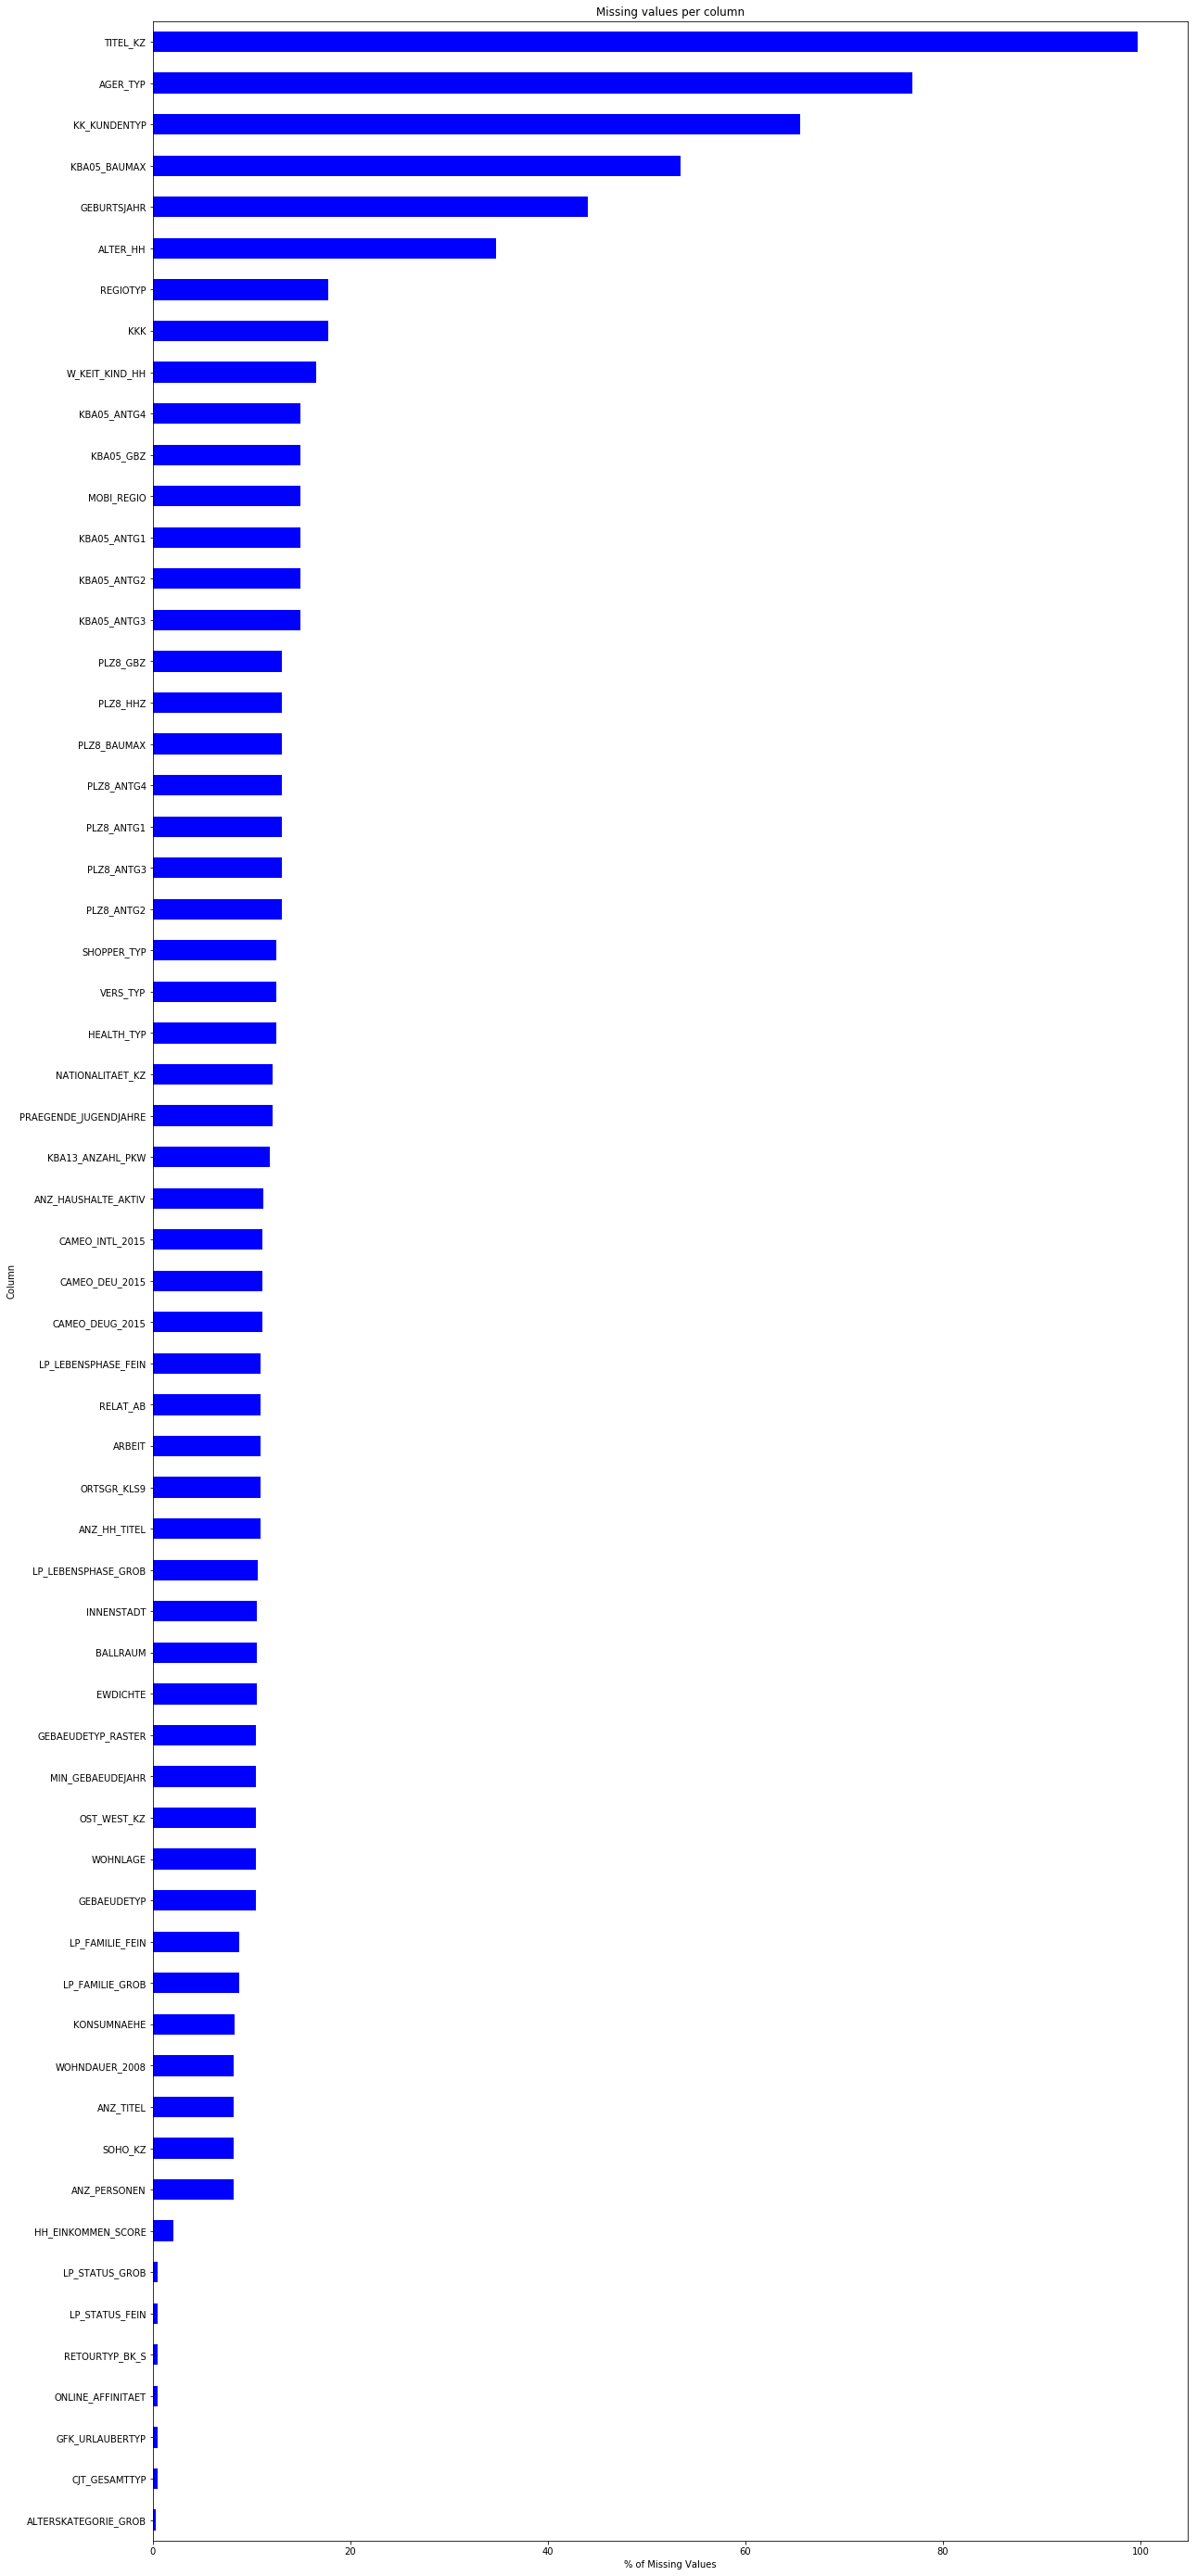

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data_azdias = azdias.isnull().sum()
#Converting the columns that have missing values as percentage
missing_data_azdias= (missing_data_azdias[missing_data_azdias>0]/azdias.shape[0])*100
#Sort missing values in Ascending Order
missing_data_azdias.sort_values(ascending=True, inplace=True)

#Plotting the horizontal bar
m_barh = missing_data_azdias.plot.barh(figsize=(20,50), color='blue')

plt.title('Missing values per column')
plt.xlabel('% of Missing Values')
plt.ylabel('Column')
plt.show()

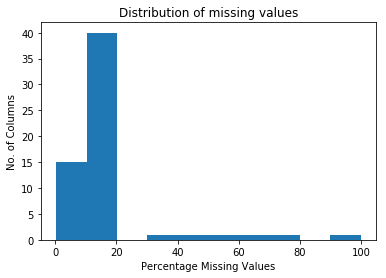

In [11]:
# Investigate patterns in the amount of missing data in each column.

#Plotting histogram to show distribution 
plt.hist(missing_data_azdias)
plt.title('Distribution of missing values')
plt.ylabel('No. of Columns')
plt.xlabel('Percentage Missing Values')
plt.show()

* Most of the columns have less than 20% of missing values.
* We are dropping all the other columns. 

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

to_drop = missing_data_azdias[missing_data_azdias>20].index
print('Columns with more than 20% missing values: \n')
[print(i) for i in to_drop]

azdias = azdias.drop(to_drop, axis=1)


Columns with more than 20% missing values: 

ALTER_HH
GEBURTSJAHR
KBA05_BAUMAX
KK_KUNDENTYP
AGER_TYP
TITEL_KZ


#### Discussion 1.1.2: Assess Missing Data in Each Column

* The raw data had 85 columns. Out of these, 6 columns had more than 20% of missing values. These columns are dropped.

Droped columns are:

1. ALTER_HH
2. GEBURTSJAHR
3. KBA05_BAUMAX
4. KK_KUNDENTYP
5. AGER_TYP
6. TITEL_KZ



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.




In [13]:
# How much data is missing in each row of the dataset?
missing_data_rows = azdias.isnull().sum(axis=1)
missing_data_rows.describe()


count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

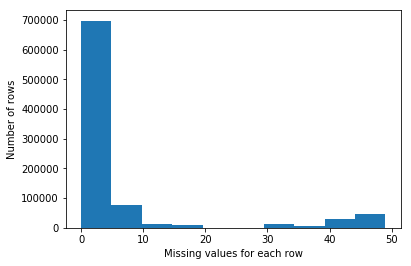

In [14]:
plt.hist(missing_data_rows)
plt.xlabel('Missing values for each row')
plt.ylabel('Number of rows')
plt.show()

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
df_missing_data = azdias.loc[azdias.isnull().sum(axis=1).sort_values(ascending=False) > 20]
azdias = azdias.loc[azdias.isnull().sum(axis=1).sort_values(ascending=False) <= 20]

In [16]:
df_missing_data.shape

(93795, 79)

In [17]:
azdias.shape

(797426, 79)

In [18]:
cols_to_plot = list(azdias.isnull().sum().sort_values().index[:5])
cols_to_plot

['ZABEOTYP', 'ANZ_TITEL', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL']

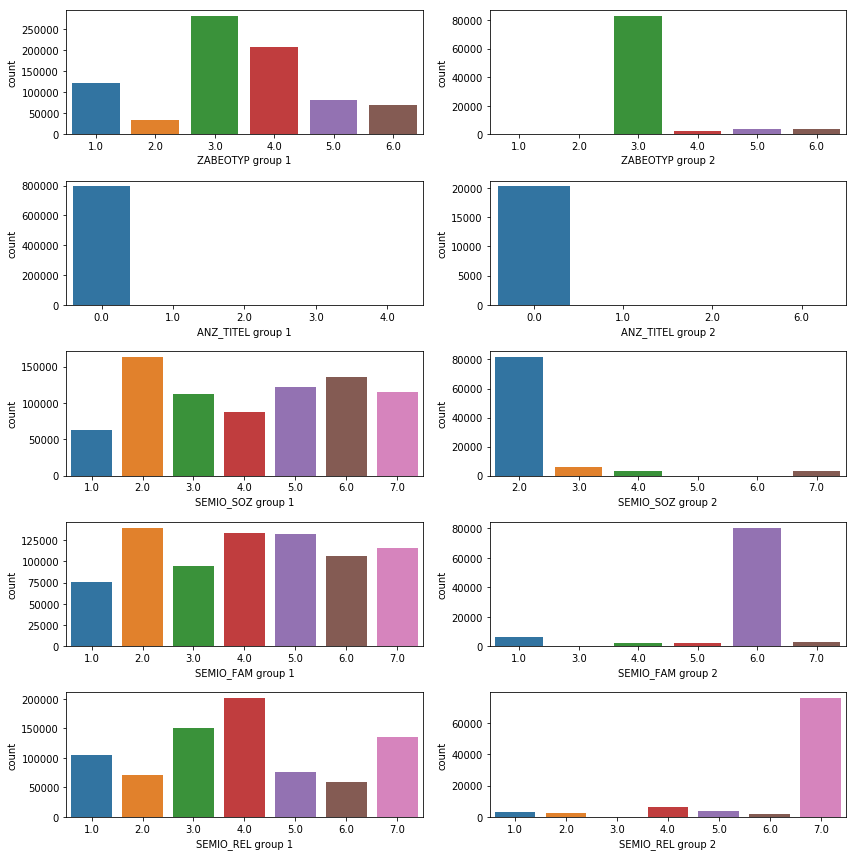

In [19]:
plt.figure(figsize=(12, 12))
for index, col in enumerate(cols_to_plot):
    plt.subplot(len(cols_to_plot), 2, index * 2 + 1)
    sns.countplot(x=col, data=azdias)
    plt.xlabel(col + ' group 1')
    plt.subplot(len(cols_to_plot), 2, index * 2 + 2)
    sns.countplot(x=col, data=df_missing_data )
    plt.xlabel(col + ' group 2')
    
plt.tight_layout()


#### Discussion 1.1.3: Assess Missing Data in Each Row

* Performed analysis on the missing values in each row.

* 93795 rows had more than 20 missing values, and these rows were dropped.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

In [20]:
# How many features are there of each data type?

print('Number of features of each data type')
print(feat_info.type.value_counts())

Number of features of each data type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_type = feat_info[feat_info['type']=='categorical']
categorical_type

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Storing are binary or multi-level columns 
binary =[]
multi =[]

for i in categorical_type['attribute']:
    if  i in azdias:  #to check if column is in 'drop_azdias' as some columns already dropped from original dataset
        if azdias[i].nunique()>2:
            multi.append(i)
        else:
            binary.append(i)

print('Binary categorical columns: ')
print(binary)

print('\nMulti categorical columns: ')
print(multi)


Binary categorical columns: 
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multi categorical columns: 
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [23]:
#Find binary data columns containing non-numeric values
for i in binary:
    if i in azdias:
        print(i)
        print(azdias[i].unique())

ANREDE_KZ
[ 2.  1.]
GREEN_AVANTGARDE
[ 0.  1.]
SOHO_KZ
[ 1.  0.]
VERS_TYP
[  2.   1.  nan]
OST_WEST_KZ
['W' 'O']


In [24]:
#Replace 'W' with '1' and 'O' with '2' for 'OST_WEST_KZ'
azdias['OST_WEST_KZ'] = azdias.loc[:,'OST_WEST_KZ'].replace(['W', 'O'], [0,1])

In [25]:
#To check for multi-level categorical features
for i in multi:
    if i in azdias:
        print(i)
        print(azdias[i].unique())

CJT_GESAMTTYP
[  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP
[ 1.  6.  5.  2.  4.  3.]
GFK_URLAUBERTYP
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
LP_FAMILIE_FEIN
[  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB
[  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN
[  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB
[  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ
[  1.   3.   2.  nan]
SHOPPER_TYP
[  3.   2.   1.   0.  nan]
ZABEOTYP
[ 5.  3.  4.  1.  6.  2.]
GEBAEUDETYP
[ 8.  1.  3.  2.  6.  4.  5.]
CAMEO_DEUG_2015
['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [26]:
#To drop 'CAMEO_DEU_2015' as it is alphanumeric
azdias.drop(['CAMEO_DEU_2015'], axis=1)
azdias_encoded = pd.get_dummies(azdias, columns=multi)

#### Discussion 1.2.1: Re-Encode Categorical Features

* Performed analysis on he categorical features. There are binary as well as multi-level categorical features in the dataset.

* As the variable 'OST_WEST_KZ' has string values, it was encoded to numerical values.

* As the variable 'CAMEO_DEU_2015' has both sting and numercial values, it was dropped.

* Encoded categorical data using pd.get_dummies() so that itcould be given as input to ML models.



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. 


In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

mixed_categories = feat_info[feat_info['type']=='mixed']
mixed_categories

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


## PRAEGENDE_JUGENDJAHRE

* Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

### Possible Values (Taken from data dictionary)
* -1: unknown
* 0: unknown
* 1: 40s - war years (Mainstream, E+W)
* 2: 40s - reconstruction years (Avantgarde, E+W)
* 3: 50s - economic miracle (Mainstream, E+W)
* 4: 50s - milk bar / Individualisation (Avantgarde, E+W)
* 5: 60s - economic miracle (Mainstream, E+W)
* 6: 60s - generation 68 / student protestors (Avantgarde, W)
* 7: 60s - opponents to the building of the Wall (Avantgarde, E)
* 8: 70s - family orientation (Mainstream, E+W)
* 9: 70s - peace movement (Avantgarde, E+W)
* 10: 80s - Generation Golf (Mainstream, W)
* 11: 80s - ecological awareness (Avantgarde, W)
* 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
* 13: 80s - Swords into ploughshares (Avantgarde, E)
* 14: 90s - digital media kids (Mainstream, E+W)
* 15: 90s - ecological awareness (Avantgarde, E+W)

In [28]:
#decade dict
decade_dict = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}

#movement dict, where 1 is mainstream and 2 is avantgarde
movement_dict = {1:1, 3:1, 5:1, 8:1, 10:1, 12:1, 14:1, 2:2, 4:2, 6:2, 7:2, 9:2, 11:2, 13:2, 15:2}

In [29]:
azdias_data = azdias_encoded.loc[:,:]

#Create Generation by decade column 'PRAEGENDE_JUGENDJAHRE_DECADE'
azdias_data['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_data.loc[:,'PRAEGENDE_JUGENDJAHRE']
azdias_data['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade_dict, inplace=True)

In [30]:
#Create Movement column 'PRAEGENDE_JUGENDJAHRE_Movement'
azdias_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_data.loc[:,'PRAEGENDE_JUGENDJAHRE']
azdias_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement_dict, inplace=True)

## CAMEO_INTL_2015

* German CAMEO: Wealth / Life Stage Typology, mapped to international code

### Possible values(Taken from data dictionary)

* -1: unknown
* 11: Wealthy Households - Pre-Family Couples & Singles
* 12: Wealthy Households - Young Couples With Children
* 13: Wealthy Households - Families With School Age Children
* 14: Wealthy Households - Older Families & Mature Couples
* 15: Wealthy Households - Elders In Retirement
* 21: Prosperous Households - Pre-Family Couples & Singles
* 22: Prosperous Households - Young Couples With Children
* 23: Prosperous Households - Families With School Age Children
* 24: Prosperous Households - Older Families & Mature Couples
* 25: Prosperous Households - Elders In Retirement
* 31: Comfortable Households - Pre-Family Couples & Singles
* 32: Comfortable Households - Young Couples With Children
* 33: Comfortable Households - Families With School Age Children
* 34: Comfortable Households - Older Families & Mature Couples
* 35: Comfortable Households - Elders In Retirement
* 41: Less Affluent Households - Pre-Family Couples & Singles
* 42: Less Affluent Households - Young Couples With Children
* 43: Less Affluent Households - Families With School Age Children
* 44: Less Affluent Households - Older Families & Mature Couples
* 45: Less Affluent Households - Elders In Retirement
* 51: Poorer Households - Pre-Family Couples & Singles
* 52: Poorer Households - Young Couples With Children
* * 53: Poorer Households - Families With School Age Children
* 54: Poorer Households - Older Families & Mature Couples
* 55: Poorer Households - Elders In Retirement
* XX: unknown

In [31]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Ordinal Value 'ones' in column 'CAMEO_INTL_2015_TENS'
azdias_data['CAMEO_INTL_2015_ONES'] = azdias_data['CAMEO_INTL_2015']

#Replace NaN with 0
azdias_data['CAMEO_INTL_2015_ONES'] = pd.to_numeric(azdias_data['CAMEO_INTL_2015_ONES'], errors='coerce')

azdias_data['CAMEO_INTL_2015_ONES'] = azdias_data['CAMEO_INTL_2015_ONES'].mod(10, fill_value=0)

azdias_data['CAMEO_INTL_2015_ONES'].head()


1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_ONES, dtype: float64

In [32]:
# Ordinal Value 'tens' in column 'CAMEO_INTL_2015_TENS'
azdias_data['CAMEO_INTL_2015_TENS'] = azdias_data['CAMEO_INTL_2015']

#Replace NaN with 0
azdias_data['CAMEO_INTL_2015_TENS'] = pd.to_numeric(azdias_data['CAMEO_INTL_2015_TENS'], errors='coerce')

azdias_data['CAMEO_INTL_2015_TENS'] =azdias_data['CAMEO_INTL_2015_TENS'].div(10, fill_value=0).astype(int)

azdias_data['CAMEO_INTL_2015_TENS'].head()

1    5
2    2
3    1
4    4
5    5
Name: CAMEO_INTL_2015_TENS, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

* Extracted relevant features from 2 mixed data type variables.

* 'PRAEGENDE_JUGENDJAHRE_MOVEMENT' was split into 'PRAEGENDE_JUGENDJAHRE_DECADE' and 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'.

* 'CAMEO_INTL_2015' was split to 'CAMEO_INTL_2015_ONES'  and 'CAMEO_INTL_2015_TENS'.

* All the details of the variables are available in the data dictionary. 

* As we have extracted relevant features, the above 2 variables will be dropped. 



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [33]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# dropping original columns
engineered_col_to_drop = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
azdias_data = azdias_data.drop(engineered_col_to_drop, axis = 1)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [34]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x.replace('[', '').replace(']', '').split(','))
    mis_or_unk_count = 0

    for col in df.columns:
        codes = feat_info[feat_info['attribute'] == col]['missing_or_unknown'].iloc[0]
        mis_or_unk_count += df[col].isin(codes).sum()
        df.loc[df[col].isin(codes), col] = np.nan

    #dropping cols with more than 20% missing values
    cols_to_drop = [ALTER_HH, GEBURTSJAHR, KBA05_BAUMAX, KK_KUNDENTYP, AGER_TYP, TITEL_KZ]
    df = df.drop(to_drop, axis=1)

    #dropping rows with lots of missing data
    df = df.loc[df.isnull().sum(axis=1).sort_values(ascending=False) <= 20]

    print(f'Dataframe shape after removing missing rows and cols = {df.shape}')

    categorical_type = feat_info[feat_info['type']=='categorical']

    binary =[]
    multi =[]

    for i in categorical_type['attribute']:
        if  i in df:  #to check if column is in 'drop_azdias' as some columns already dropped from original dataset
            if df[i].nunique()>2:
                multi.append(i)
        else:
            binary.append(i)
            

    #Replace 'W' with '1' and 'O' with '2' for 'OST_WEST_KZ'
    df['OST_WEST_KZ'] = df.loc[:,'OST_WEST_KZ'].replace(['W', 'O'], [0,1])


    #To drop 'CAMEO_DEU_2015' as it is alphanumeric
    #df.drop(['CAMEO_DEU_2015'], axis=1)
    df_encoded = pd.get_dummies(df, columns=multi)

    mixed_categories = feat_info[feat_info['type']=='mixed']

    #decade dict
    decade_dict = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}

    #movement dict, where 1 is mainstream and 2 is avantgarde
    movement_dict = {1:1, 3:1, 5:1, 8:1, 10:1, 12:1, 14:1, 2:2, 4:2, 6:2, 7:2, 9:2, 11:2, 13:2, 15:2}


    df_data = df_encoded.loc[:,:]   
    #Create Generation by decade column 'PRAEGENDE_JUGENDJAHRE_DECADE'
    df_data['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_data.loc[:,'PRAEGENDE_JUGENDJAHRE']
    df_data['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade_dict, inplace=True) 

    #Create Movement column 'PRAEGENDE_JUGENDJAHRE_Movement'
    df_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_data.loc[:,'PRAEGENDE_JUGENDJAHRE']
    df_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement_dict, inplace=True)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    # Ordinal Value 'ones' in column 'CAMEO_INTL_2015_TENS'
    df_data['CAMEO_INTL_2015_ONES'] = df_data['CAMEO_INTL_2015']

    #Replace NaN with 0
    df_data['CAMEO_INTL_2015_ONES'] = pd.to_numeric(df_data['CAMEO_INTL_2015_ONES'], errors='coerce')
    df_data['CAMEO_INTL_2015_ONES'] = df_data['CAMEO_INTL_2015_ONES'].mod(10, fill_value=0)

    # Ordinal Value 'tens' in column 'CAMEO_INTL_2015_TENS'
    df_data['CAMEO_INTL_2015_TENS'] = df_data['CAMEO_INTL_2015']

    #Replace NaN with 0
    df_data['CAMEO_INTL_2015_TENS'] = pd.to_numeric(df_data['CAMEO_INTL_2015_TENS'], errors='coerce')

    df_data['CAMEO_INTL_2015_TENS'] = df_data['CAMEO_INTL_2015_TENS'].div(10, fill_value=0).astype(int)

    # dropping original columns
    engineered_col_to_drop = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
    df_data = df_data.drop(engineered_col_to_drop, axis = 1)

    return df_data

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 


In [35]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print(f'Total number of NaN in dataframe before processing: {azdias_data.isnull().sum().sum()}')

azdias_data = azdias_data.fillna(method='ffill')
azdias_data = azdias_data.fillna(0)

azdias_columns = azdias_data.keys().tolist()

print(f'Total number of NaN in dataframe after processing: {azdias_data.isnull().sum().sum()}')

Total number of NaN in dataframe before processing: 859083
Total number of NaN in dataframe after processing: 0


In [36]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
cols = azdias_data.columns

# azdias_data_scaled = scaler.fit_transform(azdias_data)
# scaled_azdiaz_data = pd.DataFrame(azdias_data_scaled, columns=list(azdias_data))

scaled_azdiaz_data = scaler.fit_transform(azdias_data)

### Discussion 2.1: Apply Feature Scaling

* Performed feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.



In [37]:
# Apply PCA to the data.

pca=PCA()
pca.fit(scaled_azdiaz_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

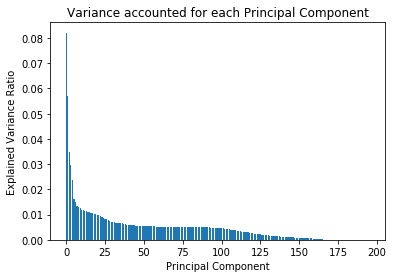

In [38]:
# Investigate the variance accounted for by each principal component.

#Explained var ratio bar plot
explained_var_ratio = pca.explained_variance_ratio_
plt.bar(range(len(explained_var_ratio)), explained_var_ratio)
plt.title('Variance accounted for each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

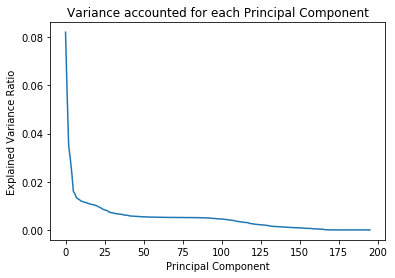

In [39]:
#Explained var ratio plot
plt.plot(range(len(explained_var_ratio)), explained_var_ratio)
plt.title('Variance accounted for each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

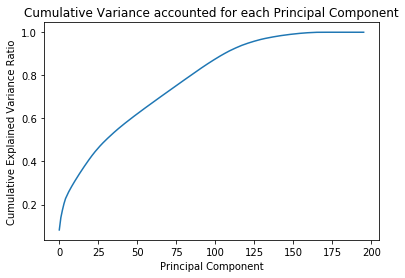

In [40]:
#Cumulative sum of explained var ratio plot
plt.plot(range(len(explained_var_ratio)), explained_var_ratio.cumsum())
plt.title('Cumulative Variance accounted for each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [41]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_75 = PCA(n_components=75)

pca75_azdias = pca_75.fit_transform(scaled_azdiaz_data)

### Discussion 2.2: Perform Dimensionality Reduction

* According to the plots, it would be ideal to use 125 components as it retains all the variance.

* As of now, 75 of the principal components are retained as it explained  almost 80 percent of the variance, and it takes a lot of time to run the scripts with more components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.



In [42]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(df,pca,i):
    weights = pd.DataFrame(pca.components_, columns=list(df))
    weights_sorted = weights.iloc[i].sort_values(ascending=False)
    return weights_sorted

def plot_component_weights(df, pca, component, feature_plot):
    component_weights = pca_weights(df, pca, component)
    component_weights = pd.concat([component_weights.head(feature_plot), component_weights.tail(feature_plot)])
    
    component_weights.plot(kind='bar')
    plt.title('Component {}'.format(component+1))
    plt.ylabel('Weight')
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()
    
    return component_weights

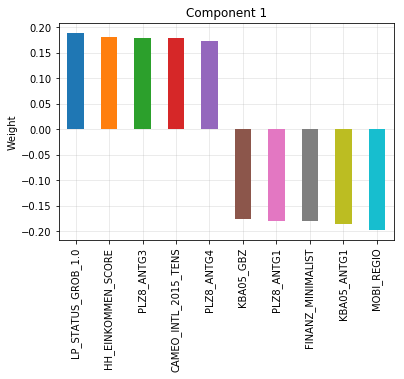

LP_STATUS_GROB_1.0      0.189498
HH_EINKOMMEN_SCORE      0.180713
PLZ8_ANTG3              0.178953
CAMEO_INTL_2015_TENS    0.178169
PLZ8_ANTG4              0.173803
KBA05_GBZ              -0.176027
PLZ8_ANTG1             -0.179520
FINANZ_MINIMALIST      -0.180415
KBA05_ANTG1            -0.184931
MOBI_REGIO             -0.198030
Name: 0, dtype: float64

In [43]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#pca_weights(scaled_azdiaz_data, pca_125, 0)
component_weights_0 = plot_component_weights(azdias_columns, pca_75, 0, 5)
component_weights_0

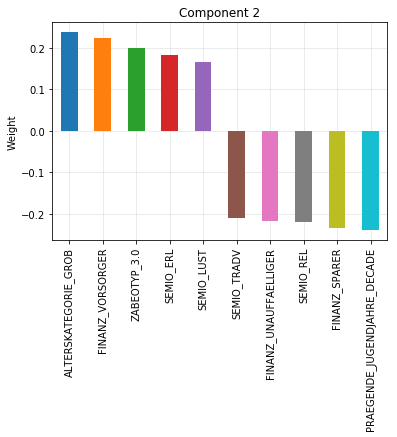

ALTERSKATEGORIE_GROB            0.237293
FINANZ_VORSORGER                0.223401
ZABEOTYP_3.0                    0.199514
SEMIO_ERL                       0.181627
SEMIO_LUST                      0.166179
SEMIO_TRADV                    -0.210793
FINANZ_UNAUFFAELLIGER          -0.217369
SEMIO_REL                      -0.218275
FINANZ_SPARER                  -0.233990
PRAEGENDE_JUGENDJAHRE_DECADE   -0.238145
Name: 1, dtype: float64

In [44]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#pca_weights(scaled_azdiaz_data, pca_125, 1)
component_weights_1 = plot_component_weights(azdias_columns, pca_75, 1, 5)
component_weights_1

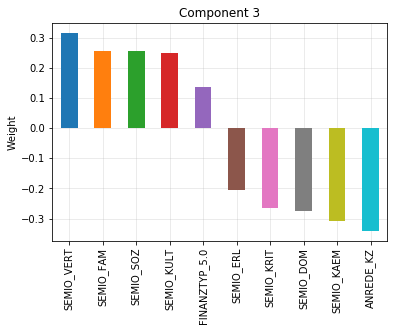

SEMIO_VERT       0.315515
SEMIO_FAM        0.256177
SEMIO_SOZ        0.254587
SEMIO_KULT       0.247687
FINANZTYP_5.0    0.136778
SEMIO_ERL       -0.205711
SEMIO_KRIT      -0.265394
SEMIO_DOM       -0.276268
SEMIO_KAEM      -0.308579
ANREDE_KZ       -0.340054
Name: 2, dtype: float64

In [45]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#pca_weights(scaled_azdiaz_data, pca_125, 2)
component_weights_2 = plot_component_weights(azdias_columns, pca_75, 2, 5)
component_weights_2

### Discussion 2.3: Interpret Principal Components

* Analyzed component1, component2 and component3.

#### Component1
The top 5 highly correlated features and their descriptions are 
    1. LP_STATUS_GROB_1.0: socail status which measures the income
    2. HH_EINKOMMEN_SCORE: Estimated household net income
    3. PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
    4. CAMEO_INTL_2015_TENS: Feature engineered column which measures wealth
    5. PLZ8_ANTG4:Number of 10+ family houses in the PLZ8 region

* It is clear from the descriptions that this component is positively correlated with the income levels.

The least correlated  5 features and their descriptions are 

    1. KBA05_GBZ: Number of buildings in the microcell          
    2. PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region           
    3. FINANZ_MINIMALIST: Financial typology    
    4. KBA05_ANTG1 : Number of 1-2 family houses in the microcell           
    5. MOBI_REGIO: Movement patterns
    
* The least correlated features are related to the type/strucutre of buildings in the region.

#### Component2
The top 5 highly correlated features are 
    1. ALTERSKATEGORIE_GROB: Estimated age based on given name analysis  
    2. FINANZ_VORSORGER: Financial typology, be prepared   
    3. ZABEOTYP_3.0: Energy consumption typology, fair supplied               
    4. SEMIO_ERL: Personality typology, relogious       
    5. SEMIO_LUST: Personality typology, sensual-minded 

* According to the desriptions, this component is highly correlated to the overall personality of the person by checking various factors like age, financial status, religious personality, average energy consumption etc.

The least correlated  5 features and their descriptions are 

    1. SEMIO_TRADV: Personality typology, tradional-minded           
    2. FINANZ_UNAUFFAELLIGER: Financial typology, inconspicuous
    3. SEMIO_REL:Personality typology, religious
    4. FINANZ_SPARER: Financial typology, money-saver
    5. PRAEGENDE_JUGENDJAHRE_DECADE:  PLZ8 macro-cell features
    
* The least correlated features favor traditional-minded religious and money-saver individuals.'

#### Component3
The top 5 highly correlated features are 
    1. SEMIO_VERT:Personality typology, dreamful
    2. SEMIO_FAM:Personality typology, family-minded
    3. SEMIO_SOZ:Personality typology, socially-minded
    4. SEMIO_KULT:Personality typology, cultural-minded
    5. FINANZTYP_5.0: investor (ANLEGER)

* According to the data descriptions, this component looks highly correlated to dreamful, family-oriented, socially minded, cultural minded personality types who are financialy sound and ivestors.  

The least correlated  5 features and their descriptions are 

    1. SEMIO_ERL: Personality typology, event-oriented     
    2. SEMIO_KRIT: Personality typology, critical-minded     
    3. SEMIO_DOM: Personality typology, dominant-minded         
    4. SEMIO_KAEM: Personality typology, combative attitude         
    5. ANREDE_KZ: Gender     
  
* This component is not favoring individuals with dominant and critical minded personality type.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.



In [46]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
cluster_count = 10
number_clusters = np.arange(1, cluster_count + 1)
k_scores = []

for i in number_clusters:
    kmeans = KMeans(n_clusters=i)
    k_model = kmeans.fit(pca75_azdias)
    score = np.abs(k_model.score(pca75_azdias))
    k_scores.append(score)

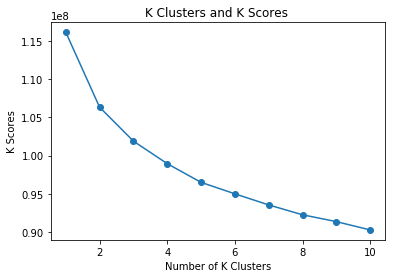

In [47]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(number_clusters, k_scores, marker='o', linestyle='-')
plt.xlabel('Number of K Clusters')
plt.ylabel('K Scores')
plt.title('K Clusters and K Scores ')
plt.show()


In [48]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 8)
general_k_model = kmeans.fit(pca75_azdias)
general_k_model_predict = general_k_model.predict(pca75_azdias)


### Discussion 3.1: Apply Clustering to General Population

* Used Elbow method, and decided to move forward with 8 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.



In [57]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head(5)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [83]:
customers_df = clean_data(customers)

Dataframe shape after removing missing rows and cols = (141640, 79)


In [70]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


#Use ffill to fill NaN values in customer data
customers_df = customers_df.fillna(method='ffill')
customers_df = customers_df.fillna(0)

customers_cols = customers_df.keys().tolist()

#Use Standard Scaler to scale the customer data
scaled_customer = customers_df[:]
scaled_customer = scaler.fit_transform(scaled_customer)

In [71]:
# PCA the scaled customer data
#pca_customer = pca_125.fit_transform(scaled_customer_df)
pca_customer = pca_75.fit_transform(scaled_customer)

In [72]:
#Using the k model from general_k_model to predict customers data

cust_k_model_predict = general_k_model.predict(pca_customer)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.



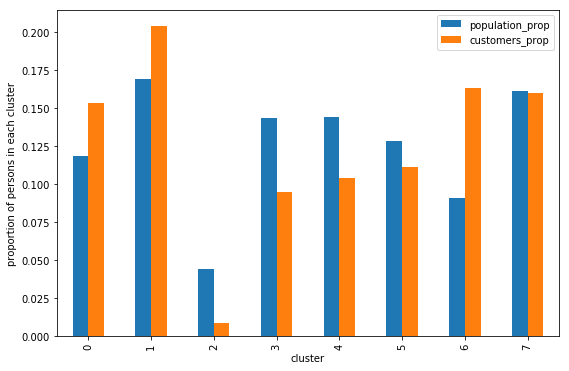

In [76]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

population_prop = []
customers_prop = []
x = [i for i in range(8)]
for i in range(8):
    population_prop.append((general_k_model_predict == i).sum()/len(general_k_model_predict))
    customers_prop.append((cust_k_model_predict == i).sum()/len(cust_k_model_predict))


df_general = pd.DataFrame({'cluster' : x, 'population_prop' : population_prop, 'customers_prop':customers_prop})
df_general.plot(x='cluster', y = ['population_prop', 'customers_prop'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_6 = scaler.inverse_transform(pca_75.inverse_transform(general_k_model.cluster_centers_[6]))
over_cluster_6 = pd.Series(data = cluster_6, index = customers_df.columns)


In [78]:
# Sort values ascending = False
over_cluster_6 = over_cluster_6.sort_values(ascending=False)
over_cluster_6.head(20)

MIN_GEBAEUDEJAHR                1991.889444
KBA13_ANZAHL_PKW                 672.529849
PRAEGENDE_JUGENDJAHRE_DECADE      46.119217
LP_LEBENSPHASE_FEIN               25.793828
WOHNDAUER_2008                     8.913224
LP_LEBENSPHASE_GROB                7.633418
SEMIO_VERT                         7.149102
SEMIO_LUST                         6.410873
ORTSGR_KLS9                        6.348484
SEMIO_SOZ                          5.447077
FINANZ_VORSORGER                   5.367523
SEMIO_KULT                         5.326766
W_KEIT_KIND_HH                     5.119115
SEMIO_FAM                          5.085611
FINANZ_MINIMALIST                  5.075583
EWDICHTE                           4.867233
RETOURTYP_BK_S                     4.731286
SEMIO_MAT                          4.642279
ANZ_HAUSHALTE_AKTIV                4.373744
CAMEO_INTL_2015_ONES               4.076145
dtype: float64

MIN_GEBAEUDEJAHR: First year building was mentioned in the database
KBA13_ANZAHL_PKW: Number of cars in the PLZ8 region
PRAEGENDE_JUGENDJAHRE_DECADE: PLZ8 macro-cell features
LP_LEBENSPHASE_FEIN: Life stage, fine scale
WOHNDAUER_2008: Length of residence
LP_LEBENSPHASE_GROB: Life stage, rough scale
SEMIO_VERT: Personality typology, dreamful
SEMIO_LUST: Personality typology, sensual-minded
ORTSGR_KLS9                        6.348484
SEMIO_SOZ                          5.447077
FINANZ_VORSORGER                   5.367523
SEMIO_KULT                         5.326766
W_KEIT_KIND_HH                     5.119115
SEMIO_FAM                          5.085611
FINANZ_MINIMALIST                  5.075583
EWDICHTE                           4.867233
RETOURTYP_BK_S                     4.731286
SEMIO_MAT                          4.642279
ANZ_HAUSHALTE_AKTIV                4.373744
CAMEO_INTL_2015_ONES               4.076145

In [79]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_3 = scaler.inverse_transform(pca_75.inverse_transform(general_k_model.cluster_centers_[3]))
under_cluster_3 = pd.Series(data = cluster_3, index = customers_df.columns)


In [80]:
# Sort values ascending = False
under_cluster_3 = under_cluster_3.sort_values(ascending=False)
under_cluster_3.head(20)

MIN_GEBAEUDEJAHR                1994.029428
KBA13_ANZAHL_PKW                 661.014545
PRAEGENDE_JUGENDJAHRE_DECADE      69.370967
LP_LEBENSPHASE_FEIN               20.197257
ANZ_HAUSHALTE_AKTIV                8.378478
WOHNDAUER_2008                     8.140045
LP_LEBENSPHASE_GROB                6.263763
SEMIO_ERL                          6.050154
SEMIO_KAEM                         5.600054
SEMIO_KRIT                         5.563640
SEMIO_DOM                          5.412302
INNENSTADT                         5.179721
REGIOTYP                           4.948382
BALLRAUM                           4.826066
WOHNLAGE                           4.612821
ORTSGR_KLS9                        4.527855
SEMIO_LUST                         4.496739
HH_EINKOMMEN_SCORE                 4.463506
SEMIO_RAT                          3.997084
FINANZ_VORSORGER                   3.891031
dtype: float64

In [82]:
# There are same categories in the 2 clusters
# To find the unique values in the 2 clusters which will be used for analysis

# Convert the category names to list
under_3 = under_cluster_3.head(20).index.tolist()
over_6 = over_cluster_6.head(20).index.tolist()

# Make a list of unique values between the 2 lists above
over_under_unique = list(set(under_3).symmetric_difference(set(over_6)))

# Make indivual list of unique category for each cluster, overreprensented and underrepresented
under_3_unique = []
over_6_unique = []

for i in over_under_unique:
    if i in under_3:
        under_3_unique.append(i)

for i in over_under_unique:
    if i in over_6:
        over_6_unique.append(i)

print('Overrepresented unique: \n',  under_3_unique)
print('Underrepresented unique: \n', over_6_unique)

Overrepresented unique: 
 ['SEMIO_KAEM', 'SEMIO_DOM', 'REGIOTYP', 'SEMIO_RAT', 'SEMIO_KRIT', 'BALLRAUM', 'WOHNLAGE', 'INNENSTADT', 'HH_EINKOMMEN_SCORE', 'SEMIO_ERL']
Underrepresented unique: 
 ['SEMIO_FAM', 'SEMIO_SOZ', 'SEMIO_KULT', 'W_KEIT_KIND_HH', 'SEMIO_MAT', 'CAMEO_INTL_2015_ONES', 'RETOURTYP_BK_S', 'SEMIO_VERT', 'FINANZ_MINIMALIST', 'EWDICHTE']


### Discussion 3.3: Compare Customer Data to Demographics Data

* Created 8 clusters for the customers as well as the general population data.
 
* Cluster6 seems to be overrepresented in the customer data compared to the general population.

* Cluster2, cluster3 and cluster4 seems to be underrepresented in the customer data compared to the general populaton.

* Analysed the top 20 features in cluster6 and cluster3. 

* There are 10 features common in both the lists.

* Unique features in cluster6 and their descriptions are

    1. 'SEMIO_KAEM': Personality typology, combative attitude
    2. 'SEMIO_DOM': Personality typology, dominant-minded
    3. 'REGIOTYP': Neighborhood typology
    4. 'SEMIO_RAT': Personality typology, rational
    5. 'SEMIO_KRIT': Personality typology, critical-minded
    6. 'BALLRAUM': Distance to nearest urban center
    7. 'WOHNLAGE': Neighborhood quality
    8. 'INNENSTADT': Distance to city center (downtown)
    9. 'HH_EINKOMMEN_SCORE': Estimated household net income
    10. 'SEMIO_ERL': Personality typology, event-oriented

* Unique features in cluster3 and their descriptions are
    1. 'SEMIO_FAM': Personality typology, family-minded
    2. 'SEMIO_SOZ': Personality typology, socially-minded
    3. 'SEMIO_KULT': Personality typology, cultural-minded
    4. 'W_KEIT_KIND_HH': Likelihood of children in household
    5. 'SEMIO_MAT': Personality typology, materialistic
    6. 'CAMEO_INTL_2015_ONES': Wealth / Life Stage Typology
    7. 'RETOURTYP_BK_S': Return type
    8. 'SEMIO_VERT': Personality typology, dreamful
    9. 'FINANZ_MINIMALIST': Financial typology
    10. 'EWDICHTE': Density of households per square kilometer

* Based on the descriptions, cluster6 reperesent individulas with rational and critical-minded personality type. Cluster3 represents family-minded and cultural-minded personalities. 

